# Importing Necesseties

In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import nltk
from nltk.corpus import stopwords
import random
import warnings
warnings.filterwarnings("ignore")

**Below is a helper Function which generates random colors which can be used to give different colors to your plots.**

In [ ]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Reading the Data

In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
train.shape

(27481, 4)

So We have 15000 tweets

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


### Check if there any missing value

In [ ]:
train.isna().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


There are no null Values in the test set

# EDA

### Show the first 5 rows

In [ ]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


Selected_text is a subset of text

### Show statistics info about the data


In [ ]:
train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11118


Lets look at the distribution of tweets in the train set

In [ ]:
train['sentiment'].value_counts()

,count
sentiment,
neutral,11118
positive,8582
negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

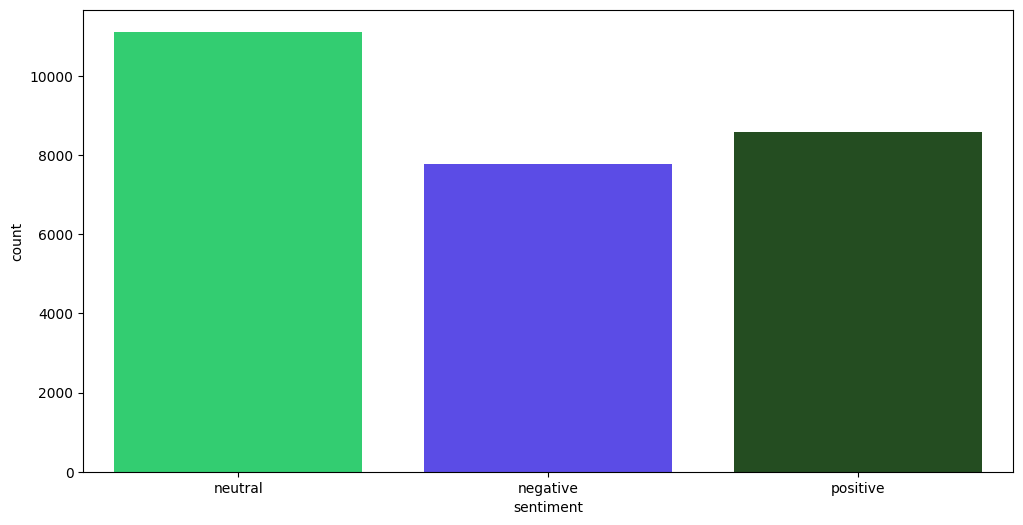

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train,palette=random_colours(3))

## What do we currently Know About our Data:

Before starting let's look at some things that we already know about the data and will help us in gaining more new insights:
* We Know that selected_text is a subset of text
* We know that selected_text contains only one segment of text,i.e,It does not jump between two sentences.For Eg:- If text is 'Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun.  I had other plans for my morning' The selected text can be 'my boss was not happy w/ them. Lots of fun' or 'Lots of fun' but cannot be 'Morning,vendor and my boss,

### Cleaning the Corpus
Now Before We Dive into extracting information out of words in text and selected text,let's first clean the data

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [ ]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative


## Most Common words in our Target-Selected Text

In [ ]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

OOPS!While we cleaned our dataset we didnt remove the stop words and hence we can see the most coomon word is 'to' . Let's try again after removing the stopwords

In [ ]:
nltk.download('stopwords')

from nltk.corpus import stopwords

# Now you can use stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)


In [ ]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

# Most Common words in Text

Let's also look at the most common words in Text

In [ ]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [ ]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


So the first two common word was I'm so I removed it and took data from second row

In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

SO we can see the Most common words in Selected text and Text are almost the same,which was obvious

# Most common words Sentiments Wise

Let's look at the most common words in different sentiments

In [ ]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

### Most common positive words

In [ ]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [ ]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

### Most common negative words

In [ ]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [ ]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

### Most common Neutral words

In [ ]:
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [ ]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

* We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis
* It will be interesting to see the word unique to different sentiments

## Let's Look at Unique Words in each Segment

We will look at unique words in each segment in the Following Order:
* Positive
* Negative
* Neutral

In [ ]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [ ]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result;
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output:
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

### Positive Tweets

In [ ]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [ ]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

In [ ]:
!pip install palettable

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 21.1 MB/s eta 0:00:00


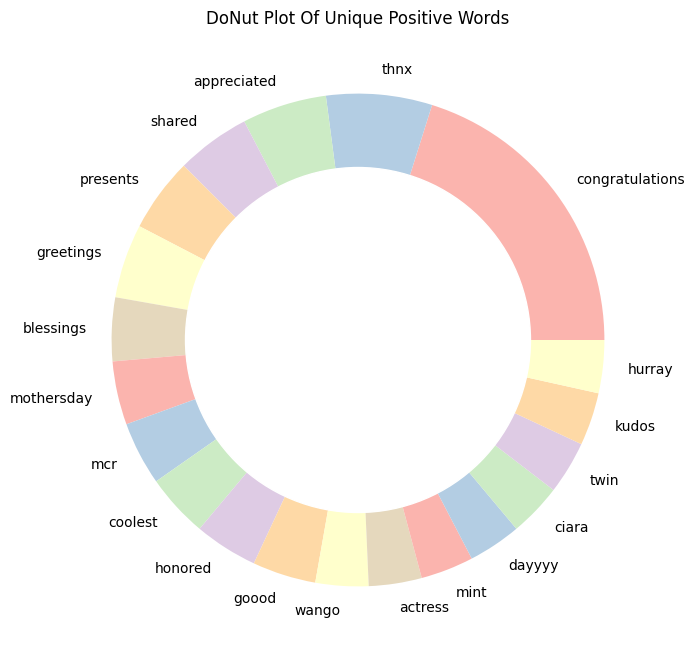

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,8))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Positive Words')
plt.show()

In [ ]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


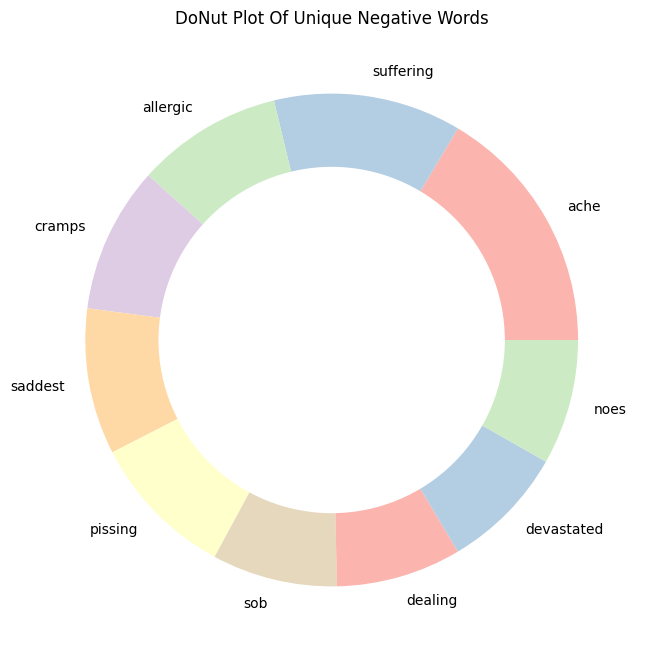

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,8))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [ ]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


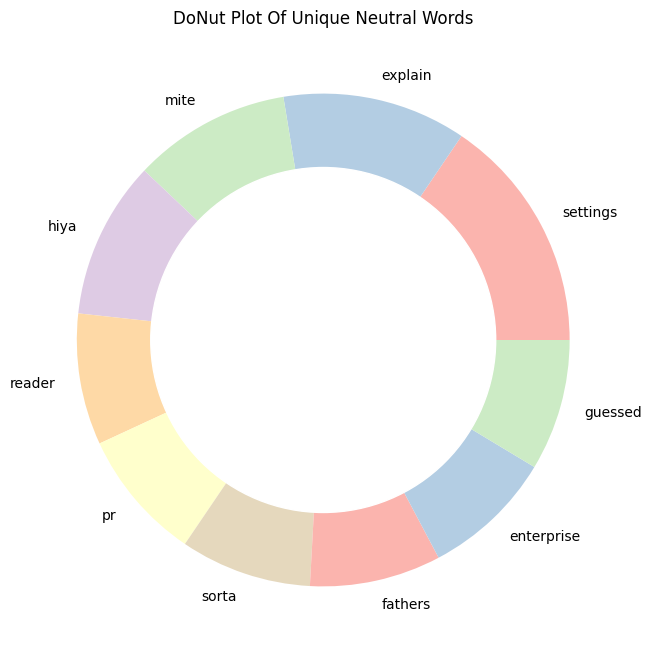

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(13,8))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

**By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets**

In [ ]:
# Check unique values in sentiment column
print(train['sentiment'].unique())

['neutral' 'negative' 'positive']


In [ ]:
# Strip spaces and convert to lowercase
train['sentiment'] = train['sentiment'].str.strip().str.lower()

# Now apply encoding
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
train['sentiment'] = train['sentiment'].map(sentiment_mapping)

# Check if there are still NaN values
train['sentiment'].isna().sum()

np.int64(0)

In [ ]:
train.head()

,textID,text,selected_text,sentiment,temp_list,temp_list1
0,cb774db0d1,id have responded if i were going,id have responded if i were going,1,"[id, responded, going]","[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,0,"[sooo, sad]","[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me,bullying me,0,[bullying],"[boss, bullying]"
3,9642c003ef,what interview leave me alone,leave me alone,0,"[leave, alone]","[interview, leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,0,[sons],"[sons, couldnt, put, releases, already, bought]"


# Trasformer Model

In [ ]:
X = train.drop(columns=['sentiment'])  # Features (excluding target)
y = train['sentiment']  # Target variable

In [ ]:
X

,textID,text,selected_text,temp_list,temp_list1
0,cb774db0d1,id have responded if i were going,id have responded if i were going,"[id, responded, going]","[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,"[sooo, sad]","[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me,bullying me,[bullying],"[boss, bullying]"
3,9642c003ef,what interview leave me alone,leave me alone,"[leave, alone]","[interview, leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,[sons],"[sons, couldnt, put, releases, already, bought]"
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,d lost,[lost],"[wish, could, come, see, u, denver, husband, l..."
27477,4f4c4fc327,ive wondered about rake to the client has ma...,dont force,"[dont, force]","[ive, wondered, rake, client, made, clear, net..."
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,"[yay, good]","[yay, good, enjoy, break, probably, need, hect..."
27479,ed167662a5,but it was worth it,but it was worth it,[worth],[worth]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train.head(1)

,textID,text,selected_text,temp_list,temp_list1
7025,da4d705179,in grade yearbook for narnia movie release bl...,in grade yearbook for narnia movie release bl...,"[grade, yearbook, narnia, movie, release, blur...","[grade, yearbook, narnia, movie, release, blur..."


In [ ]:
text = X_train["text"].values.tolist()

In [ ]:
! pip install transformers

In [ ]:
# from transformers import TFAutoModelForSequenceClassification
# from transformers import AutoModelForSequenceClassification
# from transformers import AutoTokenizer,AutoConfig
import numpy as np
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
MODEL2 = "distilbert-base-uncased"
MODEL3 = "bert-base-uncased"

### Prepare Your Data for BERT

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL3)

def tokenize_function(text):
  return tokenizer(text, padding="max_length", truncation=True ,max_length=128 ,return_tensors= "pt")

### Load and Fine-Tune the BERT Model

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(MODEL3, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Move to Gpu

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Set Up Training
- opt:Adam

In [ ]:
import torch
from  torch.optim import AdamW
# from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5) # lr is 2e-5 or 5e-5


### Data Loader and Hyper Parameters

In [ ]:
encoded_data = tokenize_function(text)

In [ ]:
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

In [ ]:
# CONVERT LABELS TO A TENSOR
labels =  torch.tensor(y_train.values) if isinstance(y_train, pd.Series) else torch.tensor(y_train)

In [ ]:
#create tensordataset
from torch.utils.data import DataLoader,TensorDataset

train_dataset= TensorDataset(input_ids,attention_masks,labels)

In [ ]:
# Create DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

### Verify the Setup

In [ ]:
# Check the first batch
for batch in train_dataloader:
    batch_input_ids, batch_attention_masks, batch_labels = batch
    print("Input IDs shape:", batch_input_ids.shape)  # Should be (batch_size, max_length)
    print("Attention Masks shape:", batch_attention_masks.shape)  # Should be (batch_size, max_length)
    print("Labels shape:", batch_labels.shape)  # Should be (batch_size,)
    break

Input IDs shape: torch.Size([16, 128])
Attention Masks shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


### Apply to Test Data

In [ ]:
test_text = X_test["text"].values.tolist()

In [ ]:
# Tokenize test data
encoded_test = tokenize_function(test_text)
test_input_ids = encoded_test['input_ids']
test_attention_masks = encoded_test['attention_mask']
test_labels = torch.tensor(y_test.values) if isinstance(y_test, pd.Series) else torch.tensor(y_test)

# Create test dataset and dataloader
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # No shuffling for evaluation

In [ ]:
# Check the first batch
for batch in test_dataloader:
    batch_input_ids, batch_attention_masks, batch_labels = batch
    print("Input IDs shape:", batch_input_ids.shape)  # Should be (batch_size, max_length)
    print("Attention Masks shape:", batch_attention_masks.shape)  # Should be (batch_size, max_length)
    print("Labels shape:", batch_labels.shape)  # Should be (batch_size,)
    break

Input IDs shape: torch.Size([16, 128])
Attention Masks shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


## Train the Model

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(epochs):
  model.train()
  for batch in train_dataloader:
    batch_input_ids, batch_attention_masks, batch_labels = [b.to(device) for b in batch]
    # optimizer.zero_grad()
    outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

## Evaluate and Optimize

In [ ]:
# optimize
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Evaluation loop
predictions, true_labels = [], []
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    for batch in test_dataloader:  # Use test_dataloader instead of eval_dataloader
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score, f1_score
print("Accuracy:", accuracy_score(true_labels, predictions))
print("F1 Score:", f1_score(true_labels, predictions, average='weighted'))

Accuracy: 0.7837002001091504
F1 Score: 0.783836580850066


In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# Evaluation function (from your optimized code)
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    total_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = outputs.loss
            total_loss += loss.item()
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    return avg_loss, accuracy, f1, predictions, true_labels

# Evaluate on test set
test_loss, test_accuracy, test_f1, test_predictions, test_true_labels = evaluate(model, test_dataloader, device)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}")

Evaluating: 100%|██████████| 344/344 [00:41<00:00,  8.20it/s]


Test Loss: 0.6821, Accuracy: 0.7837, F1 Score: 0.7838


Confusion Matrix:
[[1226  291   39]
 [ 288 1678  258]
 [  33  280 1404]]


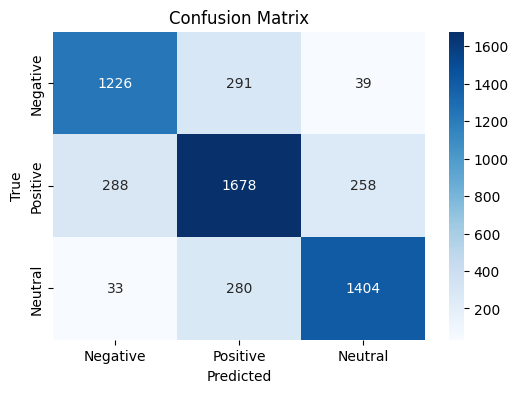


Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.79      0.79      1556
    Positive       0.75      0.75      0.75      2224
     Neutral       0.83      0.82      0.82      1717

    accuracy                           0.78      5497
   macro avg       0.79      0.79      0.79      5497
weighted avg       0.78      0.78      0.78      5497



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive','Neutral'], yticklabels=['Negative', 'Positive','Neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=['Negative', 'Positive','Neutral']))

In [ ]:
def predict_sentiment(text, model, tokenizer, device, label_mapping=None):
    # Set model to evaluation mode
    model.eval()

    # Tokenize the input text
    encoded = tokenizer(
        text,
        padding='max_length',
        max_length=128,  # Match the max_length used during training
        truncation=True,
        return_tensors='pt'
    )

    # Extract input_ids and attention_mask
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]

    # Map prediction to label (if label_mapping is provided)
    if label_mapping:
        reverse_mapping = {v: k for k, v in label_mapping.items()}
        return reverse_mapping.get(prediction, prediction)
    return prediction

# Example usage
# Assuming you used a label mapping during training (e.g., {'negative': 0, 'neutral': 1, 'positive': 2})
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
# Test examples
test_examples = [
    "I absolutely love this product, it's amazing!",
    "This is the worst experience I've ever had.",
    "The movie was okay, nothing special.",
    "I'm so happy with my purchase!",
    "I hate how slow this service is."
]

# Predict sentiment for each example
for text in test_examples:
    predicted_label = predict_sentiment(text, model, tokenizer, device, label_mapping)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {predicted_label}\n")

Text: I absolutely love this product, it's amazing!
Predicted Sentiment: positive

Text: This is the worst experience I've ever had.
Predicted Sentiment: negative

Text: The movie was okay, nothing special.
Predicted Sentiment: positive

Text: I'm so happy with my purchase!
Predicted Sentiment: positive

Text: I hate how slow this service is.
Predicted Sentiment: negative



## Save and Load the Model for Future Testing

In [ ]:
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")

('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/vocab.txt',
 'sentiment_model/added_tokens.json',
 'sentiment_model/tokenizer.json')

Inference:

In [ ]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.argmax(outputs.logits, dim=1).item()

In [ ]:
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Load the model and tokenizer
@st.cache_resource  # Cache the model and tokenizer to avoid reloading on every request
def load_model_and_tokenizer():
    model = BertForSequenceClassification.from_pretrained("sentiment_model")
    tokenizer = BertTokenizer.from_pretrained("sentiment_model")
    return model, tokenizer

model, tokenizer = load_model_and_tokenizer()

# Move model to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set model to evaluation mode

# Define the prediction function
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    # Move inputs to the correct device
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

    # Map prediction to label
    label_mapping = {0: "negative", 1: "positive"}  # Adjust based on your label mapping
    return label_mapping.get(prediction, "unknown")

# Streamlit UI
st.title("Sentiment Analysis with BERT")
st.write("Enter a piece of text to predict its sentiment (positive or negative).")

# Text input
user_input = st.text_area("Input Text", "I love this product, it's amazing!")

# Predict button
if st.button("Predict"):
    if user_input.strip() == "":
        st.error("Please enter some text to analyze.")
    else:
        with st.spinner("Analyzing sentiment..."):
            prediction = predict_sentiment(user_input)
            st.success(f"Predicted Sentiment: **{prediction}**")

# Example texts
st.write("### Try Some Examples")
examples = [
    "I absolutely love this product, it's amazing!",
    "This is the worst experience I've ever had.",
    "The movie was okay, nothing special.",
    "I'm so happy with my purchase!",
    "I hate how slow this service is."
]

for example in examples:
    if st.button(f"Predict: '{example}'"):
        prediction = predict_sentiment(example)
        st.write(f"Text: {example}")
        st.write(f"Predicted Sentiment: **{prediction}**")

# Add some information about the app
st.write("---")
st.write("This app uses a fine-tuned BERT model to predict sentiment (positive or negative) from text input. The model was trained on a sentiment analysis dataset and deployed using Streamlit.")

2025-04-04 18:07:57.167 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 18:07:57.780 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-04 18:07:57.786 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 18:07:57.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 18:07:57.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 18:07:57.953 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 18:07:58.106 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 18:07:58.106 Thread 'MainThread': mi

In [ ]:
import pickle
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Load the model and tokenizer
def load_model_and_tokenizer():

    model = BertForSequenceClassification.from_pretrained("sentiment_model")
    tokenizer = BertTokenizer.from_pretrained("sentiment_model")
    return model, tokenizer

model, tokenizer = load_model_and_tokenizer()

filename = 'sentiment_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#!ls


# Deployment

installing the library

In [ ]:
!pip install gradio pyngrok transformers torch

code for interface

In [ ]:
import gradio as gr
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Load model
model = BertForSequenceClassification.from_pretrained("sentiment_model")
tokenizer = BertTokenizer.from_pretrained("sentiment_model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prediction function
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k:v.to(device) for k,v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    pred = torch.argmax(outputs.logits).item()
    return ["Negative 😠", "Neutral 😐", "Positive 😊"][pred]

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(label="Enter your text"),
    outputs=gr.Label(label="Predicted Sentiment"),
    examples=[
        ["This product is amazing!"],
        ["Worst experience ever"],
        ["The weather is okay today"]
    ],
    title="Twitter Sentiment Analysis 🐦",
    description=" model trained on Twitter data"
)

from pyngrok import ngrok

ngrok.kill()

ngrok.set_auth_token("2ueFnbKWeilI9Nnum8wjMwTjKip_3VoB9wLLR4NgbjCXwnJno")


public_url = ngrok.connect()
#print("Public URL:", public_url)
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://074386bd81aea947f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


code test

In [ ]:
!curl -X POST "https://your-ngrok-url/predict" -H "Content-Type: application/json" -d '{"text":"I love this!"}'

curl: (6) Could not resolve host: your-ngrok-url


code that the model can last longer run

In [ ]:
from IPython.display import Javascript
Javascript('''
function keepAlive() {
    var req = new XMLHttpRequest();
    req.open("GET", "twitter_sentiment_extaction_analysis.ipynb?kernel_keep_alive=1", true);
    req.send();
}
setInterval(keepAlive, 60000);
''')

<IPython.core.display.Javascript object>

In [ ]:
#!pip install streamlit pyngrok transformers torch


In [ ]:
#!npm install -g localtunnel


In [ ]:
#!streamlit run app.py & npx localtunnel --port 8501



---

### 🐦 Twitter Sentiment Analysis App (Streamlit + BERT)

This cell sets up a **Streamlit web app** for Twitter sentiment analysis using a **BERT model**, and makes it publicly accessible via **ngrok**.

#### 🔧 What it does:
- Installs required packages (`streamlit`, `pyngrok`, `transformers`, `torch`)
- Keeps Google Colab active using JavaScript
- Saves and runs a `Streamlit` app (`app.py`) for sentiment prediction
- Loads a fine-tuned BERT model with caching
- Deploys the app via ngrok and prints the public URL

Use this to interactively test Twitter-like text for Positive 😊, Neutral 😐, or Negative 😠 sentiment.

---


In [ ]:
# Run the app with ngrok
from pyngrok import ngrok
import subprocess
import time

# Start Streamlit
!streamlit run app.py &
time.sleep(5)  # Give Streamlit time to start

# Create ngrok tunnel
public_url = ngrok.connect(8501)
print(f"Streamlit app is running at: {public_url}")

In [ ]:

import streamlit as st
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from pyngrok import ngrok
import time
import subprocess
import os
from IPython.display import Javascript, display

# Install required packages (uncomment if needed)
!pip install streamlit pyngrok transformers torch

# Keep Colab notebook from disconnecting
def keep_alive():
    display(Javascript('''
    function keepAlive() {
        var req = new XMLHttpRequest();
        req.open("GET", "twitter_sentiment_extaction_analysis.ipynb?kernel_keep_alive=1", true);
        req.send();
    }
    setInterval(keepAlive, 60000);
    '''))

# Save the Streamlit app code
with open('app.py', 'w') as f:
    f.write('''
import streamlit as st
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Load model function with caching
@st.cache_resource
def load_model():
    model = BertForSequenceClassification.from_pretrained("sentiment_model")
    tokenizer = BertTokenizer.from_pretrained("sentiment_model")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model, tokenizer, device

# Prediction function
def predict(text):
    model, tokenizer, device = load_model()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k:v.to(device) for k,v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    pred = torch.argmax(outputs.logits).item()
    return ["Negative 😠", "Neutral 😐", "Positive 😊"][pred]

# Streamlit UI
st.set_page_config(
    page_title="Twitter Sentiment Analysis 🐦",
    page_icon="🐦",
    layout="centered",
)

st.title("Twitter Sentiment Analysis 🐦")
st.markdown("Model trained on Twitter data")

# Input text area
text_input = st.text_area("Enter your text", height=100)

# Analyze button
if st.button("Analyze Sentiment"):
    if text_input:
        with st.spinner("Analyzing..."):
            result = predict(text_input)

            # Display the result with appropriate styling
            if "Negative" in result:
                st.error(result)
            elif "Positive" in result:
                st.success(result)
            else:
                st.info(result)
    else:
        st.warning("Please enter some text to analyze.")

# Example section
st.subheader("Try these examples:")
example_texts = [
    "This product is amazing!",
    "Worst experience ever",
    "The weather is okay today"
]

for i, example in enumerate(example_texts):
    if st.button(f"Example {i+1}", key=f"example_{i}"):
        st.text_area("Text", example, height=50, key=f"example_text_{i}")
        with st.spinner("Analyzing..."):
            result = predict(example)

            # Display the result with appropriate styling
            if "Negative" in result:
                st.error(result)
            elif "Positive" in result:
                st.success(result)
            else:
                st.info(result)
''')

# Function to run Streamlit with ngrok
def run_streamlit_with_ngrok():
    # Kill any existing processes
    os.system("killall -9 streamlit")
    ngrok.kill()

    # Set up ngrok
    ngrok.set_auth_token("2ueFnbKWeilI9Nnum8wjMwTjKip_3VoB9wLLR4NgbjCXwnJno")

    # Start Streamlit
    process = subprocess.Popen(["streamlit", "run", "app.py", "--server.port=8501"])
    time.sleep(3)  # Give Streamlit time to start

    # Connect ngrok
    public_url = ngrok.connect(8501)
    print(f"Streamlit app is running at: {public_url}")

    return process, public_url

# Display keep-alive script
keep_alive()

# Run the app
process, public_url = run_streamlit_with_ngrok()